In this notebook we will use the methods developed in our notebook 'Activation Maximization' to generate features learnt by the various layers in GoogLeNet

In [1]:
# import GoogLeNet 
import torch
from torchvision import models
model = models.googlenet(pretrained = True)

# freeze the parameters of the model
for param in model.parameters():
    param.requires_grad_(False)

In [2]:
# list of layers in the model
layer_names= list(map(lambda x: x[0], model.named_children()))
layer_names

['conv1',
 'maxpool1',
 'conv2',
 'conv3',
 'maxpool2',
 'inception3a',
 'inception3b',
 'maxpool3',
 'inception4a',
 'inception4b',
 'inception4c',
 'inception4d',
 'inception4e',
 'maxpool4',
 'inception5a',
 'inception5b',
 'avgpool',
 'dropout',
 'fc']

In [3]:
len(layer_names)

19

In [4]:
# create a factory function to returns a hook to store the output of each layer in a dictionary
activation = {}
def create_hook(name):
    def hook(m, i, o):
        activation[name] = o
        
    return hook    

In [5]:
# function object to normalize the input image

from torchvision import transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# function object to undo the above normalization if and when the need arises 
denormalize = transforms.Normalize(mean = [-0.485/0.229, -0.456/0.224, -0.406/0.225], std = [1/0.229, 1/0.224, 1/0.225] )

In [6]:
# function to create an image with random pixels 
# and move it to the specified device i.e. cpu or gpu
# by default we will move the image to the 'cpu'
# the default will be to turn-off the requires_grad_ attribute of the image
# if prt = True, print the shape and type of the generated image; by default prt = True 
import numpy as np
def random_image(Height = 28, Width = 28, device = 'cpu', requires_grad=False, optimizer=None, lr = 0.01, prt = True):
    img = np.single(np.random.uniform(0,1, (3, Height, Width))) # we need the pixel values to be of type float32
    im_tensor = normalize(torch.from_numpy(img)).to(device).requires_grad_(requires_grad) # normalize the image to have requisite mean and std. dev.
    if prt == True:
        print("img_shape:{}, img_dtype: {}".format(im_tensor.shape, im_tensor.dtype ))
    
    if optimizer:
        if requires_grad:
            return im_tensor, optimizer([im_tensor], lr = lr)
        else: 
            print('Error: Optimizer cannot be used on an image without setting its requires_grad_  ')
    
    return im_tensor

In [7]:
# function to massage img_tensor for using as input to plt.imshow()
def image_converter(im):
    
    # move the image to cpu
    im_copy = im.cpu()
    
    # for plt.imshow() the channel-dimension is the last
    # therefore use transpose to permute axes
    im_copy = denormalize(im_copy.clone().detach()).numpy().transpose(1,2,0)
    # clip negative values as plt.imshow() only accepts 
    # floating values in range [0,1] and integers in range [0,255]
    im_copy = im_copy.clip(0, 1) 
    
    return im_copy

In [8]:
# class to compute image gradients in pytorch

import torch.nn as nn
class RGBgradients(nn.Module):
    def __init__(self, weight): # weight is a numpy array
        super().__init__()
        k_height, k_width = weight.shape[1:]
        # assuming that the height and width of the kernel are always odd numbers
        padding_x = int((k_height-1)/2)
        padding_y = int((k_width-1)/2)
        
        # convolutional layer with 3 in_channels and 6 out_channels 
        # the 3 in_channels are the color channels of the image
        # for each in_channel we have 2 out_channels corresponding to the x and the y gradients
        self.conv = nn.Conv2d(3, 6, (k_height, k_width), bias = False, 
                              padding = (padding_x, padding_y) )
        # initialize the weights of the convolutional layer to be the one provided
        # the weights correspond to the x/y filter for the channel in question and zeros for other channels
        weight1x = np.array([weight[0], 
                             np.zeros((k_height, k_width)), 
                             np.zeros((k_height, k_width))]) # x-derivative for 1st in_channel
        
        weight1y = np.array([weight[1], 
                             np.zeros((k_height, k_width)), 
                             np.zeros((k_height, k_width))]) # y-derivative for 1st in_channel
        
        weight2x = np.array([np.zeros((k_height, k_width)),
                             weight[0],
                             np.zeros((k_height, k_width))]) # x-derivative for 2nd in_channel
        
        weight2y = np.array([np.zeros((k_height, k_width)), 
                             weight[1],
                             np.zeros((k_height, k_width))]) # y-derivative for 2nd in_channel
        
        
        weight3x = np.array([np.zeros((k_height, k_width)),
                             np.zeros((k_height, k_width)),
                             weight[0]]) # x-derivative for 3rd in_channel
        
        weight3y = np.array([np.zeros((k_height, k_width)),
                             np.zeros((k_height, k_width)), 
                             weight[1]]) # y-derivative for 3rd in_channel
        
        weight_final = torch.from_numpy(np.array([weight1x, weight1y, 
                                                  weight2x, weight2y,
                                                  weight3x, weight3y])).type(torch.FloatTensor)
        
        if self.conv.weight.shape == weight_final.shape:
            self.conv.weight = nn.Parameter(weight_final)
            self.conv.weight.requires_grad_(False)
        else:
            print('Error: The shape of the given weights is not correct')
    
    # Note that a second way to define the conv. layer here would be to pass group = 3 when calling torch.nn.Conv2d
    
    def forward(self, x):
        return self.conv(x)

In [9]:
# Scharr Filters
filter_x = np.array([[-3, 0, 3], 
                     [-10, 0, 10],
                     [-3, 0, 3]])
filter_y = filter_x.T
grad_filters = np.array([filter_x, filter_y])

# layer to compute pixel gradients using the above defined Scharr Filter
gradLayer = RGBgradients(grad_filters)

In [10]:
# function to compute gradient loss of an image 
def grad_loss(img, beta = 1, device = 'cpu'):
    
    # move the gradLayer to cuda
    gradLayer.to(device)
    gradSq = gradLayer(img.unsqueeze(0))**2
    
    grad_loss = torch.pow(gradSq.mean(), beta/2)
    
    return grad_loss

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Calculations being executed on: {}'.format(device))
model.to(device)
print('The model is on cuda: {}'.format(next(model.parameters()).is_cuda))

Calculations being executed on: cuda
The model is on cuda: True


In [12]:
# function to create the visualization of a given unit in a given layer

import cv2
from torch import optim
def visualize(layer_name, unit, H = 28, W = 28, act_wt = 0.5, upscaling_steps = 20, upscaling_factor = 1.05, optim_steps = 20):
    '''
    act_wt : factor by which to weigh the activation relative to the regulizer terms
    upscaling_steps : no. of times to upscale
    upscaling_factor : factor by which to upscale
    optim_steps : no. of times to optimize an input image before upscaling
    H : height of initial image
    W : width of initial image
    
    '''
    
    
    img_tensor = random_image(Height = H, Width = W, device = device, requires_grad = True, prt = False )
    optimized_images = {}
    
    model.eval()
    for mag_epoch in range(upscaling_steps+1):
        optimizer = optim.Adam([img_tensor], lr = 0.4)
        
        for opt_epoch in range(optim_steps):
            optimizer.zero_grad()
            model(img_tensor.unsqueeze(0))
            layer_out = activation[layer_name]
            
            # mean activation
            rms = torch.pow((layer_out[0, unit]**2).mean(), 0.5)
            # terminate if rms is nan
            if torch.isnan(rms):
                print('Error: rms was Nan; Returning ...')
                return
             
            # pixel intensity
            pxl_inty = torch.pow((img_tensor**2).mean(), 0.5)
            # terminate if pxl_inty is nan
            if torch.isnan(pxl_inty):
                print('Error: Pixel Intensity was Nan; Returning ...')
                return
              
            # image gradients
            im_grd = grad_loss(img_tensor, beta = 1, device = device)
            # terminate is im_grd is nan
            if torch.isnan(im_grd):
                print('Error: image gradients were Nan; Returning ...')
                return
              
            loss = -act_wt*rms + pxl_inty + im_grd        
            loss.backward()
            optimizer.step()
        
        # store the result of optimising the image after every 5th epoch
        img = image_converter(img_tensor) 
        if mag_epoch%5 == 0:
            optimized_images['mag_epoch'+str(mag_epoch)] = (img, rms.item())
         
        img = cv2.resize(img, dsize = (0,0), 
                         fx = upscaling_factor, fy = upscaling_factor).transpose(2,0,1) # scale up and move the color axis to be the first
        img_tensor = normalize(torch.from_numpy(img)).to(device).requires_grad_(True)
        
    return optimized_images

### Generating images for each unit in each layer

In [13]:
# store final images in a dictionary
images_for_layer = {}

In [14]:
cnt = 0
stop_after = 16 # number of layers to process before stopping
for name, layer in model.named_children():
    
    # we will skip the avg. pooling, dropout and the fully connected layer
    if name in ['avgpool', 'dropout', 'fc']:
        continue
    # register forward hook for the layer
    layer.register_forward_hook(create_hook(name))
    
    # computing the number of units in the layer
    # One way to do this is to pass an image through the model 
    # the number of the units in the layer can be inferred from the shape of the output tensor of the layer
    img_tensor = random_image(device = device, prt = False)
    model.eval()
    model(img_tensor.unsqueeze(0))
    n_units = activation[name].shape[1]
    print('\nname: {}, n_units: {}'.format(name, n_units))
    
    images_for_unit = {}
    for unit in range(n_units):
        #print('images for layer: {}, unit: {}'.format(name, unit))
        print('=', end = '')
        images_for_unit[unit] = visualize(layer_name = name, unit = unit)
    
    images_for_layer[name] = images_for_unit    
    cnt+=1
    if cnt >= stop_after:
        break
    
    


name: conv1, n_units: 64
name: maxpool1, n_units: 64
name: conv2, n_units: 64
name: conv3, n_units: 192
name: maxpool2, n_units: 192
name: inception3a, n_units: 256
name: inception3b, n_units: 480
name: maxpool3, n_units: 480
name: inception4a, n_units: 512
name: inception4b, n_units: 512
name: inception4c, n_units: 512
name: inception4d, n_units: 528
name: inception4e, n_units: 832
name: maxpool4, n_units: 832
name: inception5a, n_units: 832
name: inception5b, n_units: 1024

In [18]:
# numpy arrays are not json serializable so can't save the above dictionary to a json file
# numpy arrays can be saved in csv files but I am not sure how to store and read back the entire dictionary as is
# Individual numpy arrays can also be saved as .npz files using numpy.save but again not sure about the entire dictionary
# Thus saving the above dictionary as a pickle file seems most feasable
# I looked at the following links for json, csv, .npz and pickle files
# storing dictionaries: https://pythonspot.com/save-a-dictionary-to-a-file/
# saving to json: https://opensource.com/article/19/7/save-and-load-data-python-json
# saving to csv or npy: https://machinelearningmastery.com/how-to-save-a-numpy-array-to-file-for-machine-learning/
# saving to .npz: https://docs.scipy.org/doc/numpy/reference/generated/numpy.save.html
# saving to pickle: https://stackoverflow.com/questions/52444921/save-numpy-array-using-pickle
import pickle

In [20]:
with open('GoogLeNet_layer_visualizations.pkl', 'wb') as f:
    pickle.dump(images_for_layer, f)


In [26]:
import matplotlib.pyplot as plt

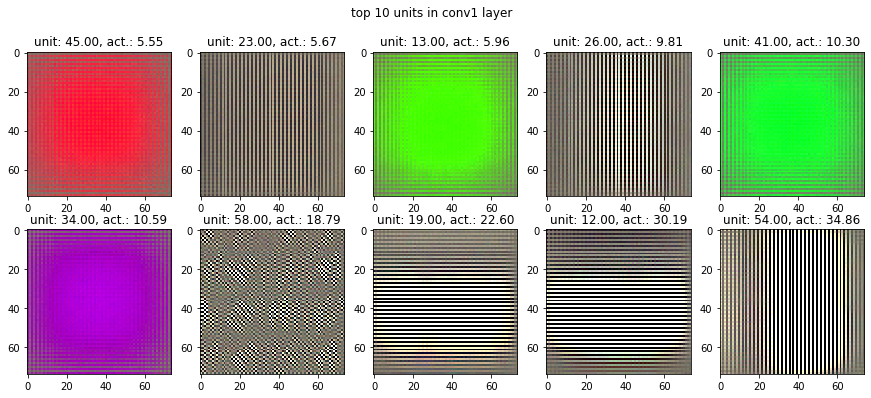

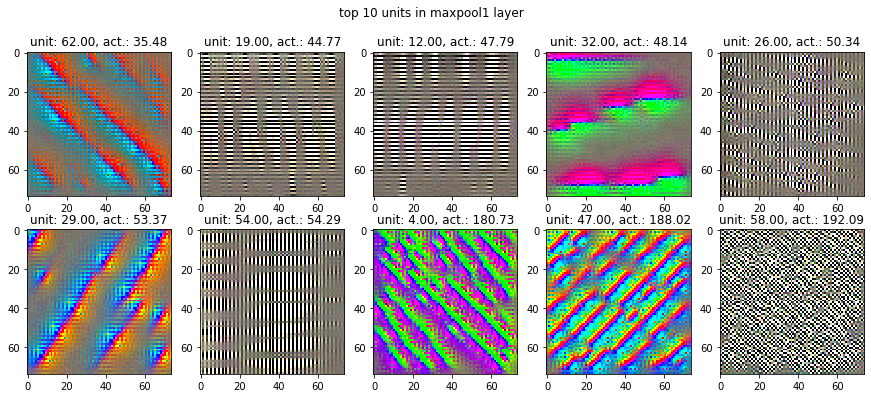

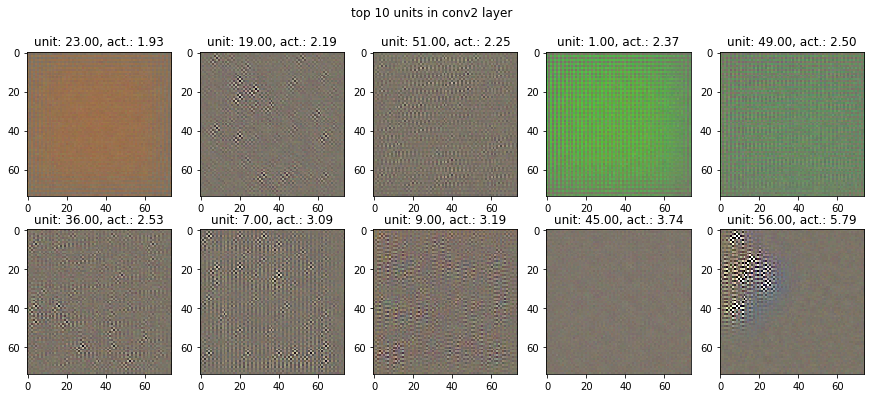

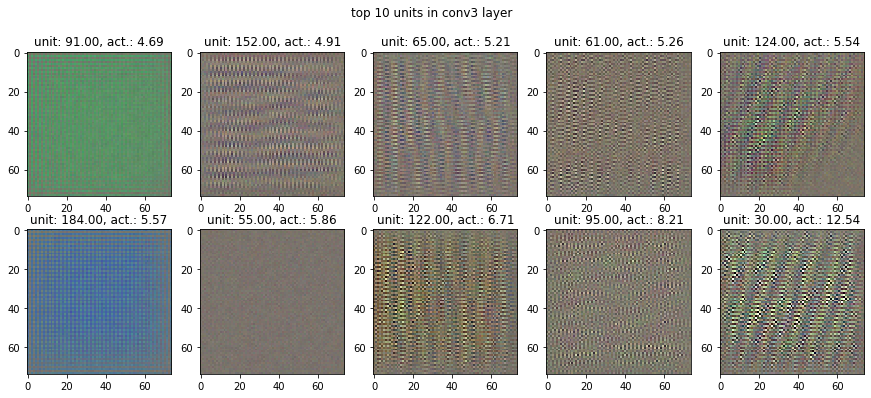

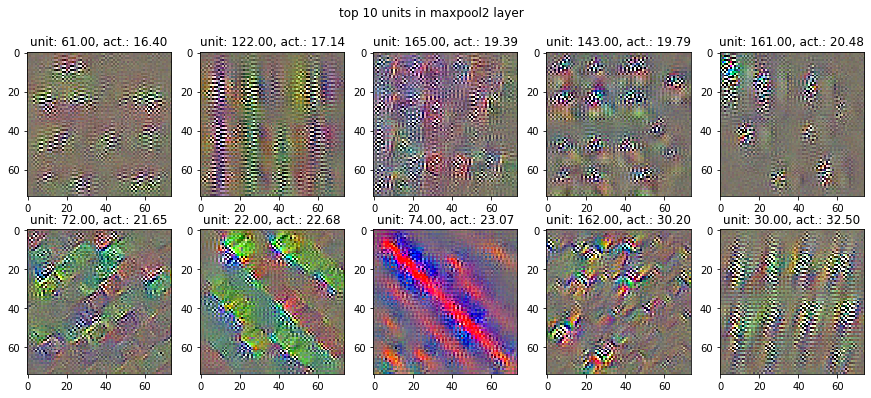

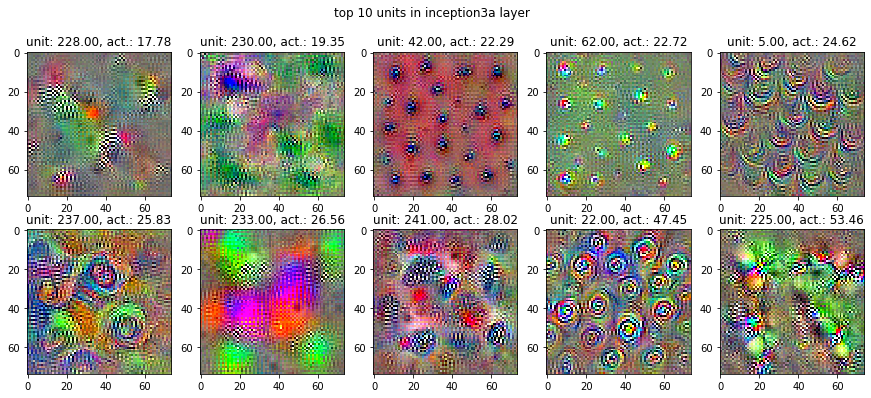

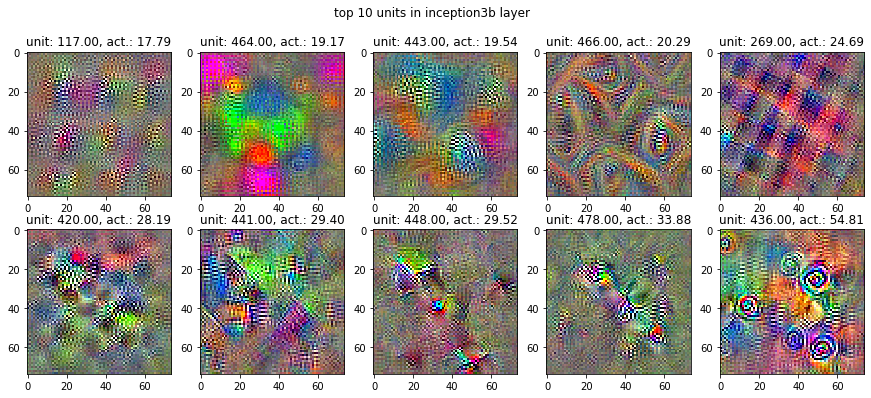

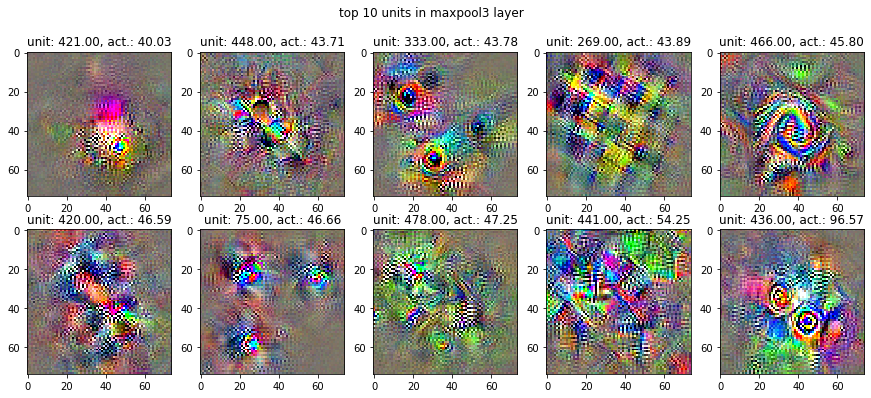

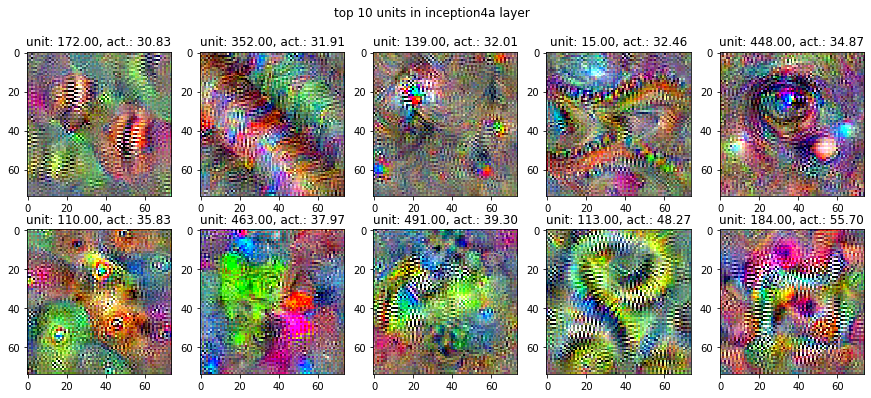

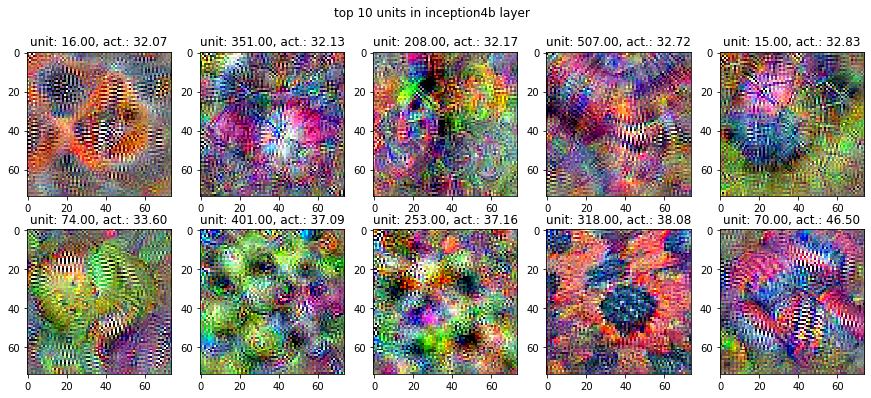

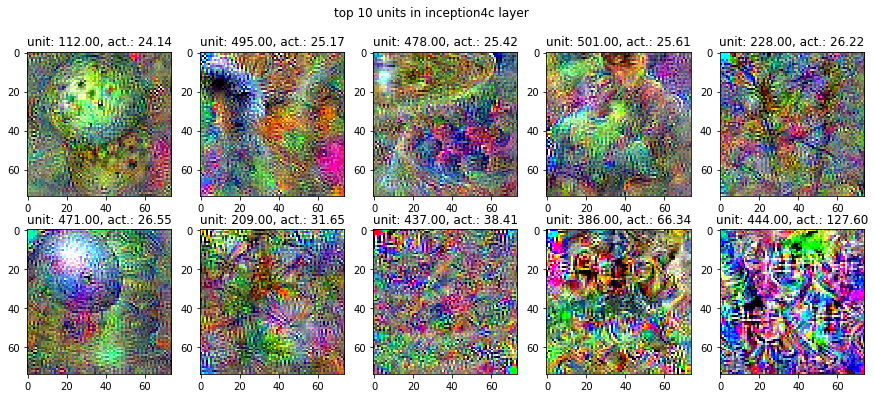

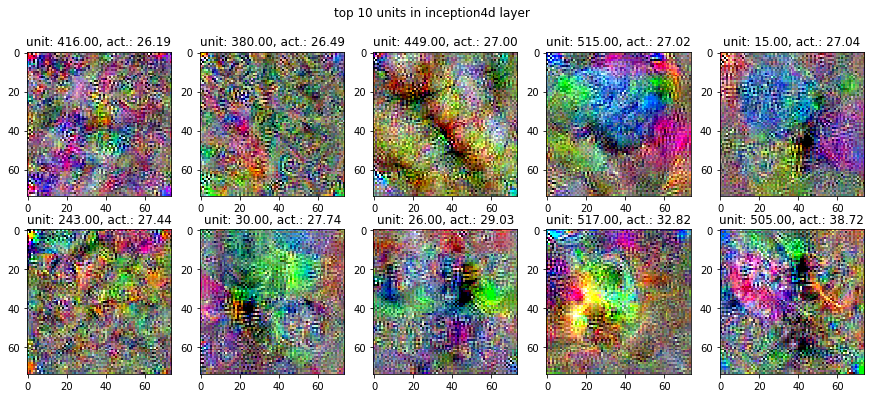

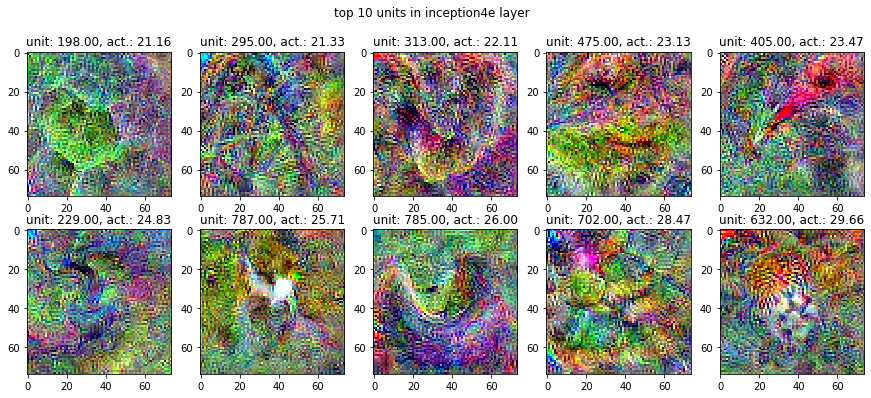

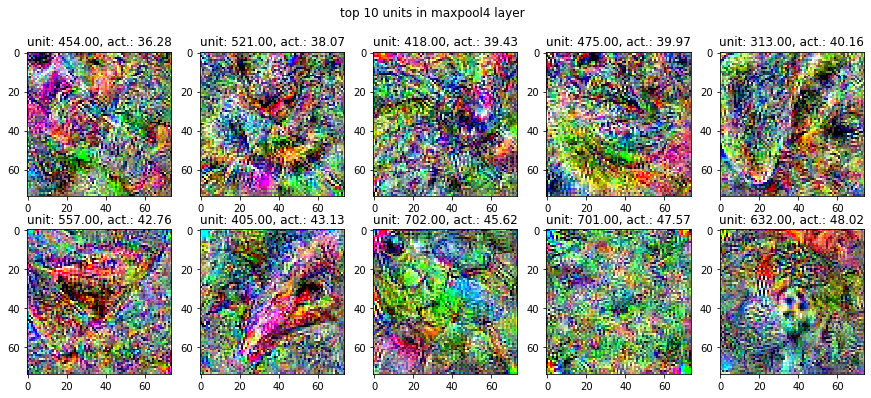

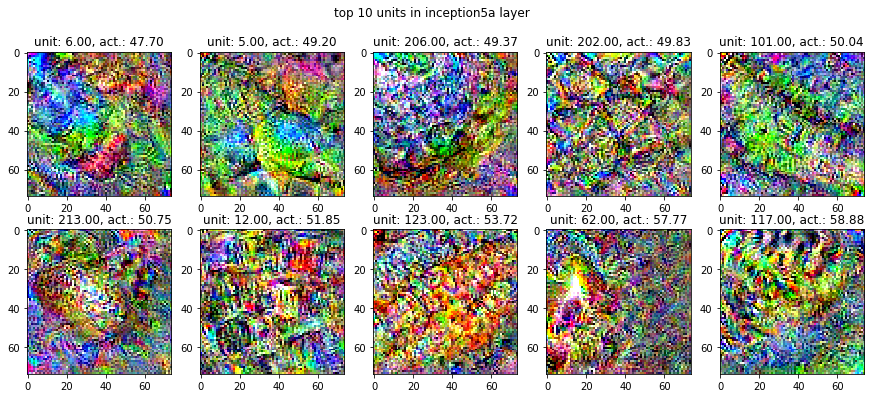

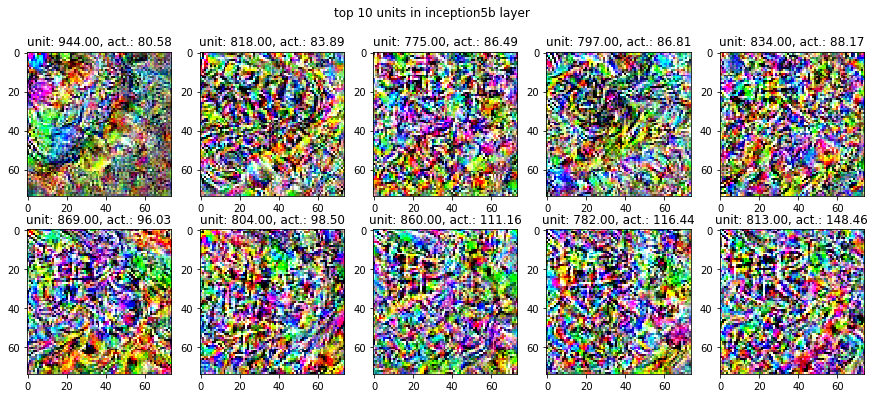

In [75]:
ctr = 0
stop_at = 16
for layer, layer_imgs in images_for_layer.items():
    if ctr >= stop_at:
        break
    ctr+=1    
    
    # find the top 10 units 
    rms_list = np.array([])
    for unit in range(len(layer_imgs)):
        rms_list = np.append(rms_list, layer_imgs[unit]['mag_epoch20'][1])
    
    top_10 = list(rms_list.argsort()[-10:]) 
    
    fig, ax = plt.subplots(figsize = (15,6), nrows = 2, ncols = 5)
    fig.suptitle('top 10 units in {} layer'.format(layer))
    for itr in range(10): 
        unit = top_10[itr]
        ax[itr//5, itr%5].imshow(layer_imgs[unit]['mag_epoch20'][0])
        ax[itr//5, itr%5].set_title('unit: {0:.2f}, act.: {1:.2f}'.format(unit, layer_imgs[unit]['mag_epoch20'][1]))
    

In [84]:
model.fc.register_forward_hook(create_hook('fc'))
model.eval()
imgs = visualize(layer_name = 'fc', unit = 10, H = 28, W = 28)

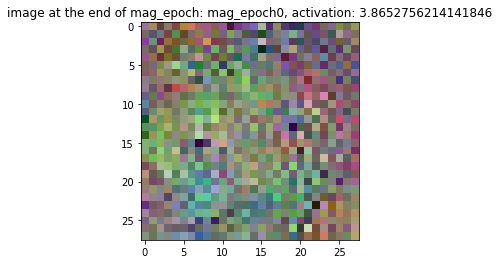

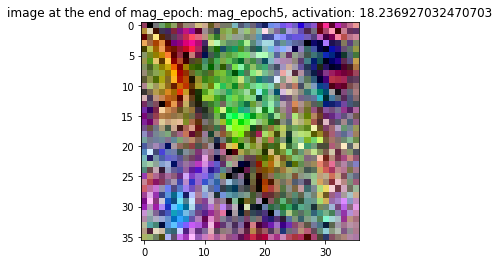

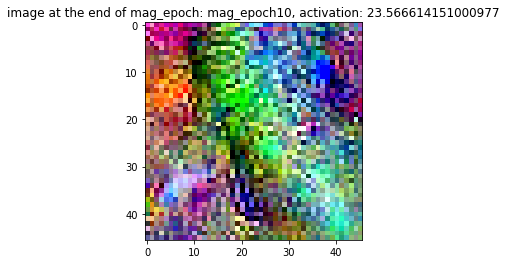

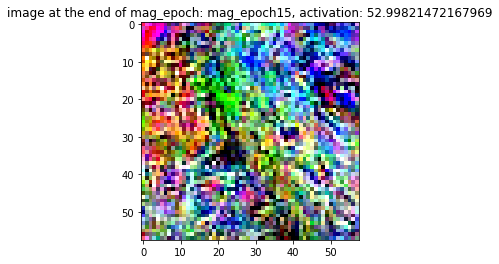

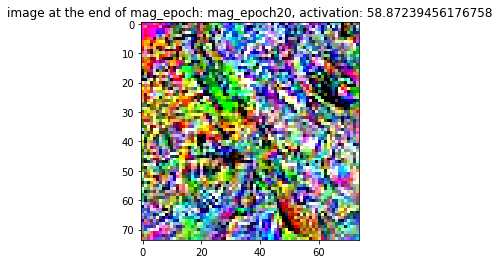

In [85]:
for key, img in imgs.items():
    plt.imshow(img[0])
    plt.title('image at the end of mag_epoch: {}, activation: {}'.format(key, img[1]))
    plt.show()